In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, linregress

circles = pd.read_csv("../data/circles.csv")
duplex = pd.read_csv("../data/duplex.csv")
shared = pd.read_csv("../data/shared.csv")
russell = pd.read_csv("../data/russell_2020_vars.csv")

In [11]:
def plot_af_correlation(
    shared_df: pd.DataFrame, log_scale: bool = True, figsize=(8, 8)
):
    """Plot allele frequency correlation with marginal boxplots."""

    circles_freq = shared_df["circles_freq_raw"].to_numpy()
    duplex_freq = shared_df["duplex_freq_raw"].to_numpy()

    # Calculate correlation and regression
    pearson_r, pearson_p = pearsonr(circles_freq, duplex_freq)
    slope, intercept, r_value, p_value, std_err = linregress(circles_freq, duplex_freq)

    # Create figure with GridSpec
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(
        2, 2, height_ratios=[1, 6], width_ratios=[6, 1], hspace=0.05, wspace=0.05
    )

    ax_main = fig.add_subplot(gs[1, 0])
    ax_box_x = fig.add_subplot(gs[0, 0], sharex=ax_main)
    ax_box_y = fig.add_subplot(gs[1, 1], sharey=ax_main)

    # Main scatter plot
    ax_main.scatter(circles_freq, duplex_freq, alpha=0.6, s=50, color="black")

    if log_scale:
        ax_main.set_xscale("log")
        ax_main.set_yscale("log")

        all_vals = np.concatenate([circles_freq, duplex_freq])
        data_min = all_vals[all_vals > 0].min() * 0.5
        data_max = all_vals.max() * 2

        ax_main.set_xlim(data_min, data_max)
        ax_main.set_ylim(data_min, data_max)
        ax_main.plot(
            [data_min, data_max], [data_min, data_max], "k--", linewidth=1.5, alpha=0.5
        )
    else:
        data_max = max(circles_freq.max(), duplex_freq.max()) * 1.05
        ax_main.set_xlim(0, data_max)
        ax_main.set_ylim(0, data_max)
        ax_main.plot([0, data_max], [0, data_max], "k--", linewidth=1.5, alpha=0.5)

    ax_main.set_xlabel("CircleSeq Allele Frequency", fontsize=12)
    ax_main.set_ylabel("IndexSeq Allele Frequency", fontsize=12)

    # Boxplots
    boxplot_style = dict(
        patch_artist=True,
        boxprops=dict(facecolor="lightgray", edgecolor="black"),
        medianprops=dict(color="black", linewidth=1.5),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        flierprops=dict(markerfacecolor="black", markeredgecolor="black", markersize=4),
    )

    ax_box_x.boxplot(circles_freq, vert=False, widths=0.5, **boxplot_style)
    ax_box_x.tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
    for spine in ax_box_x.spines.values():
        spine.set_visible(True)
    ax_box_x.set_yticks([])

    ax_box_y.boxplot(duplex_freq, vert=True, widths=0.5, **boxplot_style)
    ax_box_y.tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
    for spine in ax_box_y.spines.values():
        spine.set_visible(True)
    ax_box_y.set_xticks([])

    plt.tight_layout()

    # Print stats
    print(f"Allele Frequency Correlation:")
    print(f"  Pearson r = {pearson_r:.4f}")
    print(f"  p-value = {pearson_p:.3e}")
    print(f"  n = {len(circles_freq)}")
    print(f"  R² = {r_value**2:.4f}")
    print(f"\nLinear Regression:")
    print(f"  Slope = {slope:.4f}")
    print(f"  Intercept = {intercept:.6f}")
    print(f"\nFrequency Range:")
    print(f"  Circles: {circles_freq.min():.4f} - {circles_freq.max():.4f}")
    print(f"  Duplex:  {duplex_freq.min():.4f} - {duplex_freq.max():.4f}")

    return fig

/data/tmp/ipykernel_3247277/1062823861.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Allele Frequency Correlation:
  Pearson r = 0.6152
  p-value = 3.886e-03
  n = 20
  R² = 0.3785

Linear Regression:
  Slope = 1.4259
  Intercept = -0.001208

Frequency Range:
  Circles: 0.0014 - 0.0085
  Duplex:  0.0017 - 0.0193


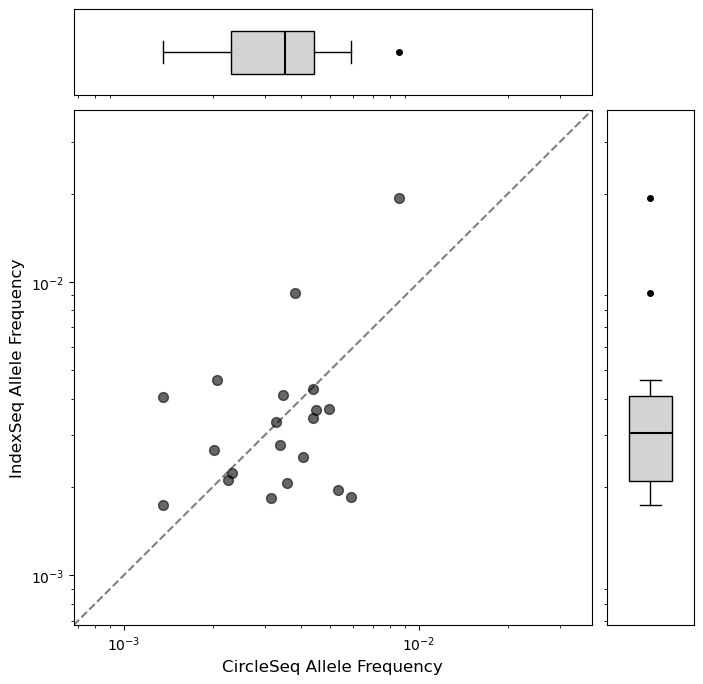

In [12]:
fig = plot_af_correlation(shared)

In [ ]:
from scipy.stats import hypergeom


def test_overlap_hypergeometric(
    circles: pd.DataFrame,
    duplex: pd.DataFrame,
    genome_size: int = 1_200_000,
) -> dict:
    """
    Test whether variant overlap exceeds chance using hypergeometric distribution.
    """
    c_keys = set(zip(circles["pos"], circles["ref"], circles["alt"]))
    d_keys = set(zip(duplex["pos"], duplex["ref"], duplex["alt"]))

    observed_overlap = len(c_keys & d_keys)
    n_circles = len(c_keys)
    n_duplex = len(d_keys)

    # Expected and variance
    expected = (n_circles * n_duplex) / genome_size
    var = (
        n_duplex
        * (n_circles / genome_size)
        * (1 - n_circles / genome_size)
        * ((genome_size - n_duplex) / (genome_size - 1))
    )

    # P(X >= observed)
    p_value = hypergeom.sf(observed_overlap - 1, genome_size, n_circles, n_duplex)

    return {
        "observed_overlap": observed_overlap,
        "expected_overlap": expected,
        "std_overlap": np.sqrt(var),
        "fold_enrichment": observed_overlap / expected,
        "p_value": p_value,
        "z_score": (observed_overlap - expected) / np.sqrt(var),
        "n_circles": n_circles,
        "n_duplex": n_duplex,
        "genome_size": genome_size,
    }


results = test_overlap_hypergeometric(circles, duplex)
results

{'observed_overlap': 48,
 'expected_overlap': 23.22289333333333,
 'std_overlap': np.float64(4.797402623373405),
 'fold_enrichment': 2.0669259127630952,
 'p_value': np.float64(4.032235950735221e-06),
 'z_score': np.float64(5.164691940999538),
 'n_circles': 6427,
 'n_duplex': 4336,
 'genome_size': 1200000}


shared:
  Ti/Tv = 3.00 (15 Ti, 5 Tv)
  vs Russell: χ² = 0.05, p = 8.22e-01

circleseq_unique:
  Ti/Tv = 0.64 (2497 Ti, 3910 Tv)
  vs Russell: χ² = 293.38, p = 9.14e-66

indexseq_unique:
  Ti/Tv = 0.56 (1558 Ti, 2758 Tv)
  vs Russell: χ² = 333.50, p = 1.66e-74

russell:
  Ti/Tv = 2.35 (589 Ti, 251 Tv)


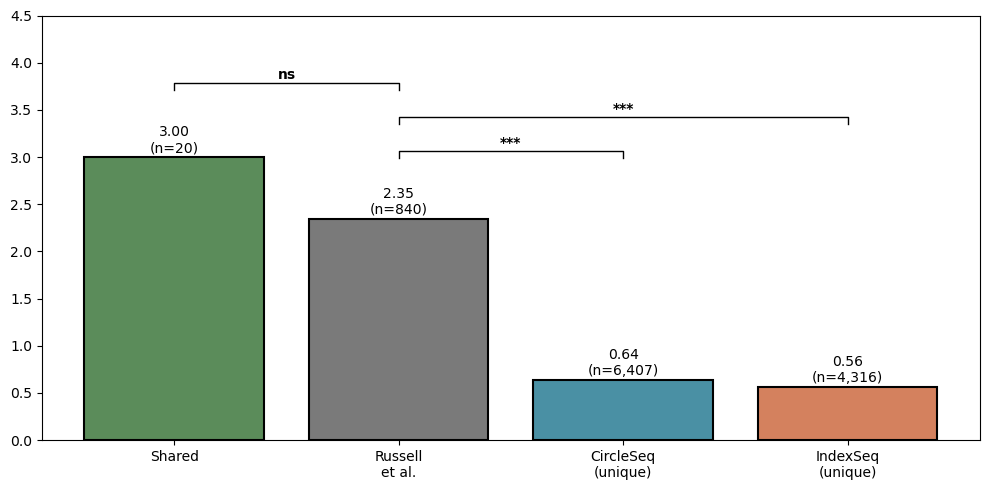

In [ ]:
TRANSITIONS = {("A", "G"), ("G", "A"), ("C", "T"), ("T", "C")}


def classify_mutation(ref: str, alt: str) -> str:
    """Classify a mutation as transition (Ti) or transversion (Tv)."""
    if (ref, alt) in TRANSITIONS:
        return "Ti"
    return "Tv"


def calc_titv_ratio(df: pd.DataFrame) -> dict:
    """
    Calculate transition/transversion ratio for a variant dataframe.

    """

    counts = df["mutation_type"].value_counts()
    n_ti = counts.get("Ti", 0)
    n_tv = counts.get("Tv", 0)

    ratio = n_ti / n_tv if n_tv > 0 else float("inf")

    return {
        "n_ti": n_ti,
        "n_tv": n_tv,
        "titv_ratio": ratio,
    }


def plot_titv_comparison(
    shared: pd.DataFrame,
    circles_filt: pd.DataFrame,
    duplex_filt: pd.DataFrame,
    russell: pd.DataFrame,
    figsize=(10, 5),
) -> tuple:
    """
    Plot Ti/Tv ratios for shared, Russell et al., CircleSeq-unique, and IndexSeq-unique variants.
    Includes chi-square tests comparing each set to Russell et al.

    Returns:
        (fig, titv_stats dict)
    """

    from scipy.stats import chi2_contingency

    # Get unique variants (not in shared set)
    shared_keys = set(zip(shared["pos"], shared["ref"], shared["alt"]))

    circles_unique = circles_filt[
        ~circles_filt.apply(
            lambda r: (r["pos"], r["ref"], r["alt"]) in shared_keys, axis=1
        )
    ]
    duplex_unique = duplex_filt[
        ~duplex_filt.apply(
            lambda r: (r["pos"], r["ref"], r["alt"]) in shared_keys, axis=1
        )
    ]

    # Calculate Ti/Tv for each set
    titv_shared = calc_titv_ratio(shared)
    titv_circles = calc_titv_ratio(circles_unique)
    titv_duplex = calc_titv_ratio(duplex_unique)
    titv_russell = calc_titv_ratio(russell)

    # Chi-square tests comparing each set to Russell
    def compare_titv(set1: dict, set2: dict) -> dict:
        """Chi-square test comparing Ti/Tv counts between two sets."""
        table = [
            [set1["n_ti"], set1["n_tv"]],
            [set2["n_ti"], set2["n_tv"]],
        ]
        chi2, p_value, dof, expected = chi2_contingency(table)
        return {"chi2": chi2, "p_value": p_value}

    comparison_shared = compare_titv(titv_shared, titv_russell)
    comparison_circles = compare_titv(titv_circles, titv_russell)
    comparison_duplex = compare_titv(titv_duplex, titv_russell)

    # Prepare data for plotting (new order: Shared, Russell, CircleSeq, IndexSeq)
    categories = [
        "Shared",
        "Russell\net al.",
        "CircleSeq\n(unique)",
        "IndexSeq\n(unique)",
    ]
    ratios = [
        titv_shared["titv_ratio"],
        titv_russell["titv_ratio"],
        titv_circles["titv_ratio"],
        titv_duplex["titv_ratio"],
    ]
    n_variants = [
        titv_shared["n_ti"] + titv_shared["n_tv"],
        titv_russell["n_ti"] + titv_russell["n_tv"],
        titv_circles["n_ti"] + titv_circles["n_tv"],
        titv_duplex["n_ti"] + titv_duplex["n_tv"],
    ]
    p_values = [
        comparison_shared["p_value"],
        None,  # Russell is reference
        comparison_circles["p_value"],
        comparison_duplex["p_value"],
    ]
    colors = [
        "#5B8C5A",
        "#7A7A7A",
        "#4A90A4",
        "#D4815E",
    ]  # sage, gray, slate blue, terracotta

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    bars = ax.bar(categories, ratios, color=colors, edgecolor="black", linewidth=1.5)

    # Add value labels on bars
    for bar, ratio, n in zip(bars, ratios, n_variants):
        label = f"{ratio:.2f}\n(n={n:,})"
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.02,
            label,
            ha="center",
            va="bottom",
            fontsize=10,
        )

    # Set y-axis to start at 0, with room for significance bars
    y_max = max(ratios) * 1.5
    ax.set_ylim(0, y_max)

    # Draw significance bars comparing to Russell (index 1)
    russell_idx = 1
    comparison_indices = [2, 3, 0]  # CircleSeq, IndexSeq, Shared
    comparison_p_values = [
        comparison_circles["p_value"],
        comparison_duplex["p_value"],
        comparison_shared["p_value"],
    ]

    def get_sig_label(p):
        if p < 0.001:
            return "***"
        elif p < 0.01:
            return "**"
        elif p < 0.05:
            return "*"
        else:
            return "ns"

    # Starting height for significance bars
    bar_height_start = max(ratios) * 1.02
    bar_height_increment = max(ratios) * 0.12

    for i, (comp_idx, p_val) in enumerate(zip(comparison_indices, comparison_p_values)):
        # Calculate bar positions
        x1 = bars[russell_idx].get_x() + bars[russell_idx].get_width() / 2
        x2 = bars[comp_idx].get_x() + bars[comp_idx].get_width() / 2

        # Stagger heights to avoid overlap
        bar_y = bar_height_start + i * bar_height_increment
        bar_tip_height = bar_height_increment * 0.2

        # Draw the significance bar (bracket)
        ax.plot(
            [x1, x1, x2, x2],
            [bar_y - bar_tip_height, bar_y, bar_y, bar_y - bar_tip_height],
            color="black",
            linewidth=1,
        )

        # Add significance label
        sig_label = get_sig_label(p_val)
        ax.text(
            (x1 + x2) / 2,
            bar_y + 0.01,
            sig_label,
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    plt.tight_layout()

    # Compile stats
    stats = {
        "shared": {**titv_shared, "vs_russell": comparison_shared},
        "circleseq_unique": {**titv_circles, "vs_russell": comparison_circles},
        "indexseq_unique": {**titv_duplex, "vs_russell": comparison_duplex},
        "russell": titv_russell,
    }

    return fig, stats


circles["mutation_type"] = circles.apply(
    lambda r: classify_mutation(r["ref"], r["alt"]), axis=1
)
duplex["mutation_type"] = duplex.apply(
    lambda r: classify_mutation(r["ref"], r["alt"]), axis=1
)
fig, stats = plot_titv_comparison(shared, circles, duplex, russell)

# Print detailed stats
for name, s in stats.items():
    print(f"\n{name}:")
    print(f"  Ti/Tv = {s['titv_ratio']:.2f} ({s['n_ti']} Ti, {s['n_tv']} Tv)")
    if "vs_russell" in s:
        p = s["vs_russell"]["p_value"]
        print(f"  vs Russell: χ² = {s['vs_russell']['chi2']:.2f}, p = {p:.2e}")

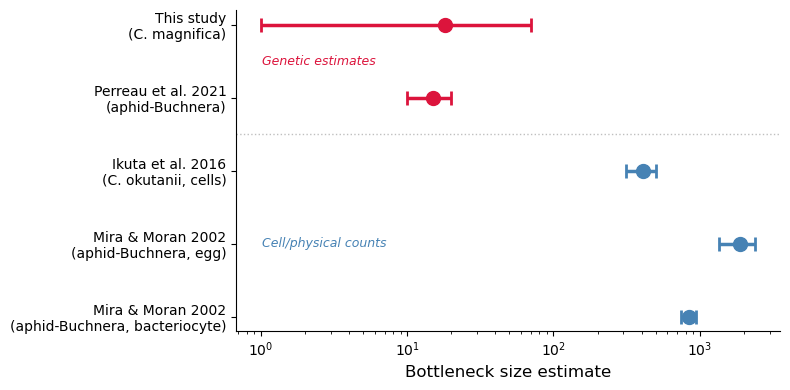

In [13]:
def plot_bottleneck_forest(
    emp_mean: float,
    emp_lower: float,
    emp_upper: float,
    figsize=(8, 4),
):
    """Forest plot comparing bottleneck estimates across studies."""

    # Data: (label, estimate, lower, upper, category)
    # category: 'genetic' or 'physical'
    studies = [
        ("This study\n(C. magnifica)", emp_mean, emp_lower, emp_upper, "genetic"),
        ("Perreau et al. 2021\n(aphid-Buchnera)", 15, 10, 20, "genetic"),
        ("Ikuta et al. 2016\n(C. okutanii, cells)", 408, 313, 503, "physical"),
        ("Mira & Moran 2002\n(aphid-Buchnera, egg)", 1872, 1348, 2396, "physical"),
        (
            "Mira & Moran 2002\n(aphid-Buchnera, bacteriocyte)",
            844,
            748,
            940,
            "physical",
        ),
    ]

    colors = {"genetic": "crimson", "physical": "steelblue"}

    fig, ax = plt.subplots(figsize=figsize)

    y_positions = list(range(len(studies)))

    for y, (label, mean, lower, upper, cat) in enumerate(studies):
        ax.errorbar(
            mean,
            y,
            xerr=[[mean - lower], [upper - mean]],
            fmt="o",
            markersize=10,
            color=colors[cat],
            elinewidth=2.5,
            capsize=5,
            capthick=2,
            zorder=3,
        )

    # Y-axis labels
    ax.set_yticks(y_positions)
    ax.set_yticklabels([s[0] for s in studies], fontsize=10)

    # X-axis
    ax.set_xscale("log")
    ax.set_xlabel("Bottleneck size estimate", fontsize=12)

    # Divider between genetic and physical estimates
    divider_y = 1.5  # between Perreau and Ikuta
    ax.axhline(divider_y, color="gray", linestyle=":", linewidth=1, alpha=0.5)

    # Category labels
    ax.text(
        ax.get_xlim()[0] * 1.5,
        0.5,
        "Genetic estimates",
        fontsize=9,
        fontstyle="italic",
        color="crimson",
        va="center",
    )
    ax.text(
        ax.get_xlim()[0] * 1.5,
        3.0,
        "Cell/physical counts",
        fontsize=9,
        fontstyle="italic",
        color="steelblue",
        va="center",
    )

    # Clean up
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.invert_yaxis()

    plt.tight_layout()
    return fig


fig = plot_bottleneck_forest(emp_mean=18, emp_lower=1, emp_upper=70)